In [21]:
import os
import json
import pandas as pd
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt
import csv

In [3]:
# Pembacaan Parameter Dataset
filename = "parameter.json"
with open(filename, 'r') as f:
    params = json.load(f)

In [4]:
# Function to read dataset.csv
def read_csv(filepath, row=True):
    df = pd.read_csv(filepath, header=None)
    if row: # row data
        data = df.T.values.tolist()[0]
    else: # comma-separated column data
        data = df.values.tolist()[0]
    return data
def read_raw(filepath):
    raw = []
    with open(filepath) as f:
        # read all lines into list of string
        lines = f.readlines()
        for line in lines:
            # remove leading and trailing white spaces and split by comma delimiter
            raw += line.strip().split(',')
    raw = [complex(s.replace('i', 'j')) for s in raw]
    return raw

In [52]:
dataset_folder = 'E:\Read-Dataset-Publik-Radar-FMCW-\Children Dataset'
radar_raw_folder = os.path.join(dataset_folder, "FMCW Radar\Rawdata")
radar_vital_folder = os.path.join(dataset_folder, "FMCW Radar\Heart Rate & Breathing Rate")
ref_raw_folder = os.path.join(dataset_folder, "Nihon Kohden\Heartbeat & Breathing Waveform")
ref_vital_folder = os.path.join(dataset_folder, "Nihon Kohden\Heart Rate & Breathing Rate")
subject_stats_folder = os.path.join(dataset_folder, "Participant\Human Data")
subject_photo_folder = os.path.join(dataset_folder, "Participant\Picture")

# Subject
subject_id = 1
radar_raw_path = os.path.join(radar_raw_folder, f"Rawdata_{subject_id}.csv")
raw_data = read_raw(radar_raw_path)## Pemanggilan Dataset Dari Folder 
# Merubah data list ke Array 
raw_data = np.asarray(raw_data, dtype=complex)
n_samples = raw_data.shape[0]//params['n_rx']
# print(raw_data.shape[0])
raw_radar = raw_data.reshape(params['n_rx'],n_samples, order='C')
raw_new = raw_radar.reshape((params['n_rx'],params['n_adc']*params['n_chirp'],-1), order='F')
#read heart rate (HR) and breath rate (BR) reading from reference device
ref_hr_path = os.path.join(ref_vital_folder, f"Ref_Heart_{subject_id}.csv")
ref_br_path = os.path.join(ref_vital_folder, f"Ref_Breath_{subject_id}.csv")
# Radar Paper
# read heart rate (HR) and breath rate (BR) estimation from radar
hr_radar_path = os.path.join(radar_vital_folder, f"Heart_{subject_id}.csv")
br_radar_path = os.path.join(radar_vital_folder, f"Breath_{subject_id}.csv")
#df_radar = pd.read_csv(hr_radar_path, header=None)
hr_radar = read_csv(hr_radar_path, row=True)
br_radar = read_csv(br_radar_path, row=True)
#df_hr = pd.read_csv(ref_hr_path, header=None)
hr = read_csv(ref_hr_path, row=False)
br = read_csv(ref_br_path, row=False)
# Waveform 
radar_br_wave_path = os.path.join(ref_raw_folder, f"Ref_Breath_Wave_{subject_id}.csv")
radar_hr_wave_path = os.path.join(ref_raw_folder, f"Ref_Heart_Wave_{subject_id}.csv")
br_wave =np.array(read_csv(radar_br_wave_path))
hr_wave =np.array(read_csv(radar_hr_wave_path,row=True))
# for i in range(1, 51):
#     radar_br_wave_path = os.path.join(ref_raw_folder, f"Ref_Breath_Wave_{i}.csv")
#     radar_hr_wave_path = os.path.join(ref_raw_folder, f"Ref_Heart_Wave_{i}.csv")
#     br_wave =np.array(read_csv(radar_br_wave_path)).reshape(1,-1)
#     hr_wave =np.array(read_csv(radar_hr_wave_path,row=True)).reshape(1,-1)
#     with open('br_wave.csv', 'a') as f: 
#         # Create a CSV writer object that will write to the file 'f'
#         csv_writer = csv.writer(f)
    
#         # Write all of the rows of data to the CSV file
#         csv_writer.writerows(br_wave)
#     with open('hr_wave.csv', 'a') as f: 
#         # Create a CSV writer object that will write to the file 'f'
#         csv_writer = csv.writer(f)
    
#         # Write all of the rows of data to the CSV file
#         csv_writer.writerows(hr_wave)

In [27]:
br_target = []
hr_target = []

with open('br_wave.csv', mode ='r')as file:
  csvFile = csv.reader(file)
  for lines in csvFile:
        br_target.append(lines)
        
with open('hr_wave.csv', mode ='r')as file:
  csvFile = csv.reader(file)
  for lines in csvFile:
        hr_target.append(lines)

In [49]:
br_target_array = []
hr_target_array = []
for i in range(0, 100, 2):
    br_target_array.append(br_target[i])
    hr_target_array.append(hr_target[i])
    
br_target_array = np.array(br_target_array).astype(np.int64)
hr_target_array = np.array(hr_target_array).astype(np.int64)

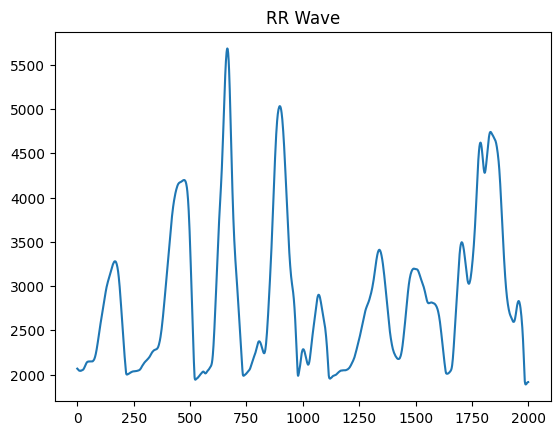

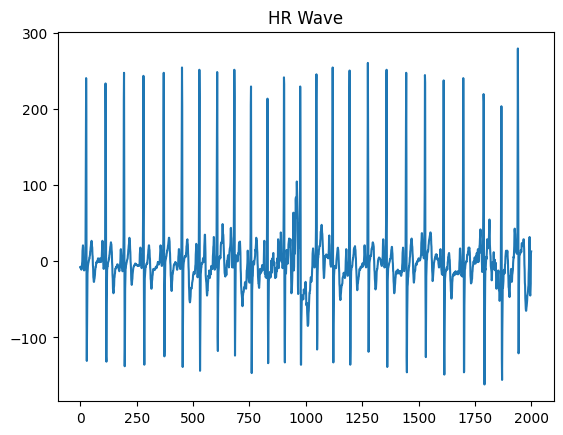

In [67]:
plt.figure(1)
plt.title("RR Wave")
plt.plot(br_target_array[0][:2000],label="RR Wave")
plt.figure(2)
plt.title("HR Wave")
plt.plot(hr_target_array[0][:2000],label="HR Wave")

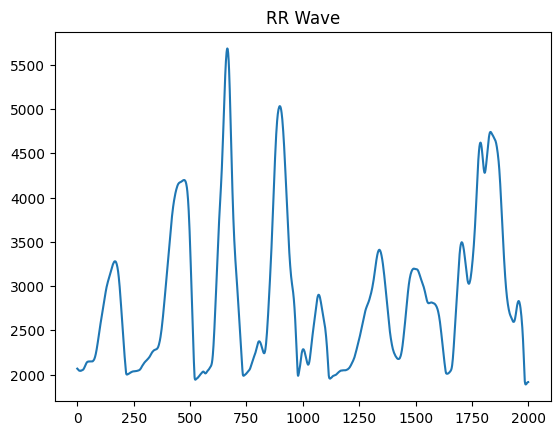

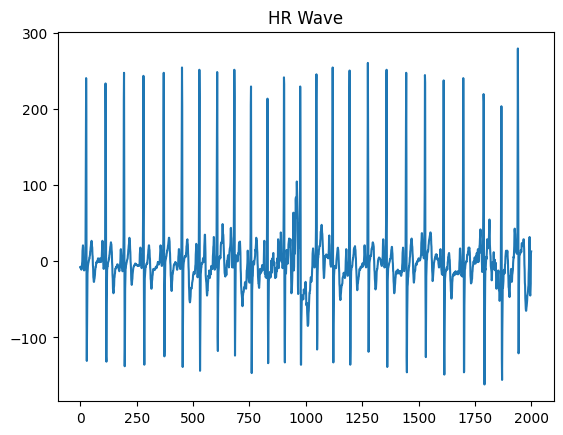

In [68]:
plt.figure(1)
plt.title("RR Wave")
plt.plot(br_target_array[0][:2000],label="RR Wave")
plt.figure(2)
plt.title("HR Wave")
plt.plot(hr_target_array[0][:2000],label="HR Wave")

In [54]:
def Range_FFT(InputData):
    OutputData = np.zeros((params['n_rx'], params['n_fft'], params['data_len']), dtype=complex)
    dc_removal = np.zeros((params['n_rx'], params['n_fft']//2, params['data_len']), dtype=complex)
    for i in range(params['n_rx']):
        for j in range(params['data_len']):
            window = np.hamming(params['n_fft'])
            dc_removal[i,:,j]= InputData[i,:,j] - np.mean(InputData[i,:,j])
            OutputData[i,:,j]= fft((dc_removal[i,:,j]), n=1024)
    return OutputData

def MTI(hasil_fft):
    clutter = np.zeros((hasil_fft.shape[0], params['n_fft'], hasil_fft.shape[-1]),dtype=complex)
    OutputData = np.zeros((hasil_fft.shape[0],params['n_fft']//2, hasil_fft.shape[-1]),dtype=complex)
    alpha = 0.01
    for i in np.arange(hasil_fft.shape[0]):
        for j in np.arange(1,hasil_fft.shape[-1]):
            clutter[i,:,j] = np.dot(alpha,hasil_fft[i,:,j])+ np.dot((1-alpha),clutter[i,:,j-1])
            OutputData[i,:,j] = hasil_fft[i,np.arange(params['n_fft']//2),j]-(clutter[i,range(0, params['n_fft']//2),j])
    return OutputData

In [55]:
# Lakukan proses FFT
FFT_hasil = Range_FFT(raw_new) # hasil FFT
Hasil_mti = MTI(FFT_hasil)

In [56]:
# Hasil MTI untuk setiap antena 
Antena1 = Hasil_mti[0,:,:]
Antena2 = Hasil_mti[1,:,:]
Antena3 = Hasil_mti[2,:,:]
Antena4 = Hasil_mti[3,:,:]

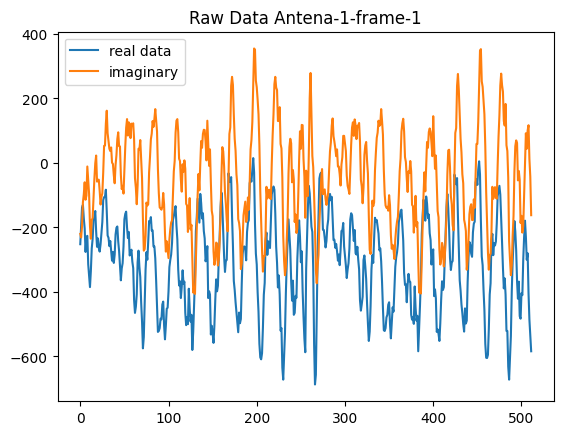

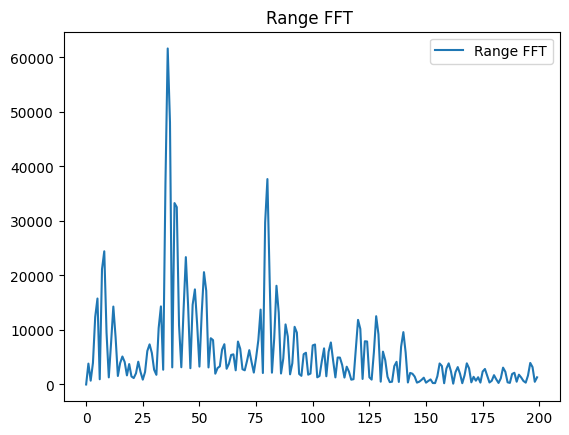

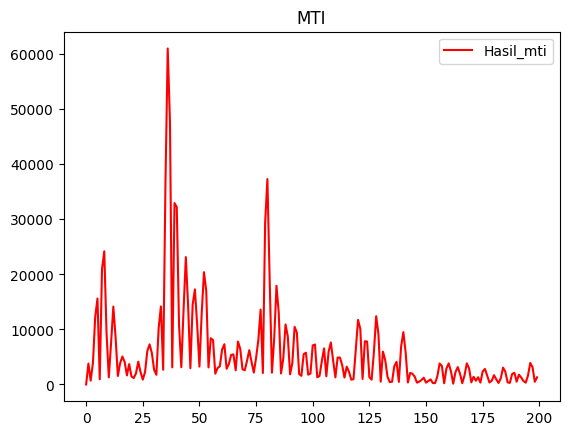

In [57]:
# Visualisasi Data 
plt.figure(1)
plt.title("Raw Data Antena-1-frame-1")
plt.plot(raw_new[0,:,1].real,label="real data")
plt.plot(raw_new[0,:,1].imag,label="imaginary")
plt.legend()
plt.figure(2)
plt.title("Range FFT ")
plt.plot(abs(FFT_hasil[0,:,1][:200]),label="Range FFT")
plt.legend()
plt.figure(3)
plt.title("MTI")
plt.plot(abs(Hasil_mti[0,:,1][:200]),label="Hasil_mti",color='r')
plt.legend()


In [58]:
import numpy as np

# Map Lokasinya 
def map_loc(data_mti):
    Range_Map_An1 = []
    index_max = []
    for i in range(1, params['data_len']):
        # Input data From MTI each Antenna 
        awal_an1 = data_mti[:, i] 
        abs_mti_1 = abs(awal_an1)
        peak_loc_an1 = np.argmax(abs_mti_1[25:60]) #pilih batas jarak
        rslt_peak_1 = 25 + peak_loc_an1
        if i > 1 and abs(rslt_peak_1 - index_max[-1]) == 10:
            # Jika perbedaan adalah 10, pilih peak tertinggi kedua
            abs_mti_1[peak_loc_an1] = 0  # Hilangkan peak pertama
            peak_loc_an1 = np.argmax(abs_mti_1[25:60])
            rslt_peak_1 = 25 + peak_loc_an1
        map_loc_an1 = awal_an1[rslt_peak_1]
        index_max.append(abs(rslt_peak_1))
        Range_Map_An1.append(map_loc_an1)
    return index_max, Range_Map_An1

# Contoh penggunaan
map_locA1, Map_loc_An1 = np.array(map_loc(Antena1))
map_locA2, Map_loc_An2 = np.array(map_loc(Antena2))
map_locA3, Map_loc_An3 = np.array(map_loc(Antena3))
map_locA4, Map_loc_An4 = np.array(map_loc(Antena4))


In [59]:
# Phase Extraction
from f_dacm import dacm
from f_noise_RM import remove_noise

DACM_An1 = np.array(dacm(np.array(Map_loc_An1)))
DACM_An2 = np.array(dacm(np.array(Map_loc_An2)))
DACM_An3 = np.array(dacm(np.array(Map_loc_An3)))
DACM_An4 = np.array(dacm(np.array(Map_loc_An4)))


Text(0.5, 0, 'Number of Samples')

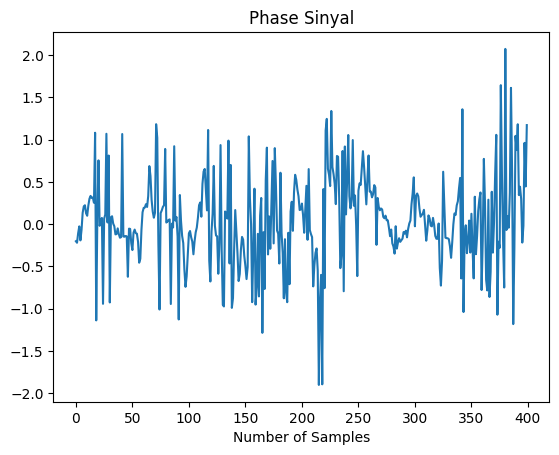

In [60]:
# 
plt.title("Phase Sinyal")
plt.plot(DACM_An1[:400])
plt.xlabel("Number of Samples")

In [61]:
# from f_noise_RM import remove_noise
NR_1 = remove_noise(DACM_An1)
NR_2 = remove_noise(DACM_An2)
NR_3 = remove_noise(DACM_An3)
NR_4 = remove_noise(DACM_An4)

In [62]:
from scipy.signal import butter, sosfiltfilt, filtfilt,lfilter
def _butter_bandpass1(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype="band", output="sos")
    # b, a = butter(order, [low, high], btype='band')
    return sos
def _butter_bandpass2(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    # sos = butter(order, [low, high], btype="band", output="sos")
    b, a = butter(order, [low, high], btype='band')
    return b,a
def butter_bandpass_filter(signal, lowcut, highcut, fs, order):
    sos = _butter_bandpass1(lowcut, highcut, fs, order=order)
    b,a = _butter_bandpass2(lowcut, highcut, fs, order=order)
    y = sosfiltfilt(sos, signal)
    y2 = filtfilt(b,a, signal)
    return y


In [63]:
low = 3/60
high = 55/60
fs = 20
BPF_RR1= np.array(butter_bandpass_filter(NR_1,low,high,fs,order=3))
BPF_RR2 = np.array(butter_bandpass_filter(NR_2,low,high,fs,order=3))
BPF_RR3 = np.array(butter_bandpass_filter(NR_3,low,high,fs,order=3))
BPF_RR4 = np.array(butter_bandpass_filter(NR_4,low,high,fs,order=3))

In [64]:
lowhr =60/60
highhr = 3.0
fs = 20
BPF_HR1 = np.array(butter_bandpass_filter(NR_1,lowhr,highhr,fs,order=6))
BPF_HR2 = np.array(butter_bandpass_filter(NR_2,lowhr,highhr,fs,order=6))
BPF_HR3 = np.array(butter_bandpass_filter(NR_3,lowhr,highhr,fs,order=6))
BPF_HR4 = np.array(butter_bandpass_filter(NR_4,lowhr,highhr,fs,order=6))

Text(0.5, 0, 'Number of Samples')

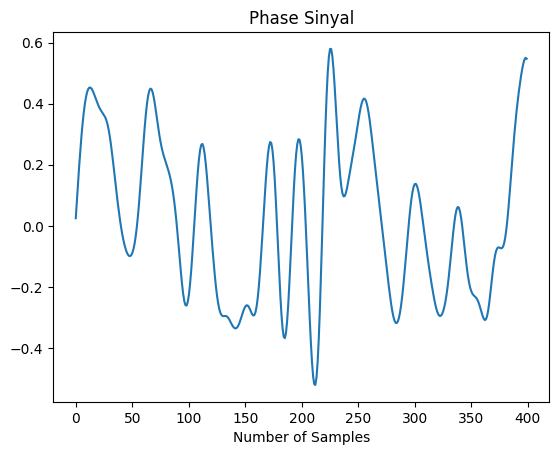

In [65]:
# 
plt.title("Phase Sinyal")
plt.plot(BPF_RR1[:400])
plt.xlabel("Number of Samples")

Text(0.5, 0, 'Number of Samples')

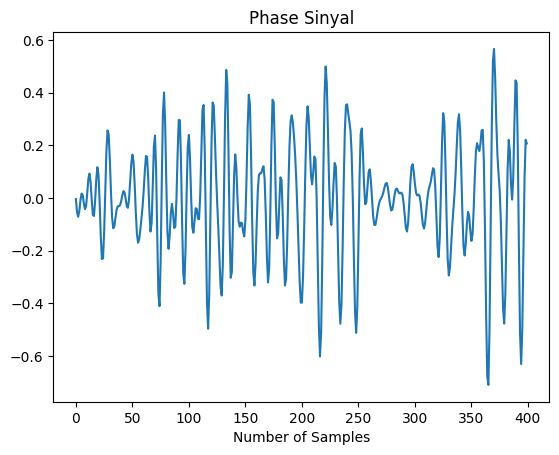

In [66]:
# 
plt.title("Phase Sinyal")
plt.plot(BPF_HR1[:400])
plt.xlabel("Number of Samples")